Data cleaning complete. Number of records after cleaning: 712
The station from which the train picked the most passengers is: S
Displaying head of the data:
   survived  pclass     sex   age  sibsp  parch     fare station
0         0       3    male  22.0      1      0   7.2500       S
1         1       1  female  38.0      1      0  71.2833       C
2         1       3  female  26.0      0      0   7.9250       S
3         1       1  female  35.0      1      0  53.1000       S
4         0       3    male  35.0      0      0   8.0500       S

Displaying data info:
<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  712 non-null    int64  
 1   pclass    712 non-null    int64  
 2   sex       712 non-null    object 
 3   age       712 non-null    float64
 4   sibsp     712 non-null    int64  
 5   parch     712 non-null    int64  
 6   fare      712 

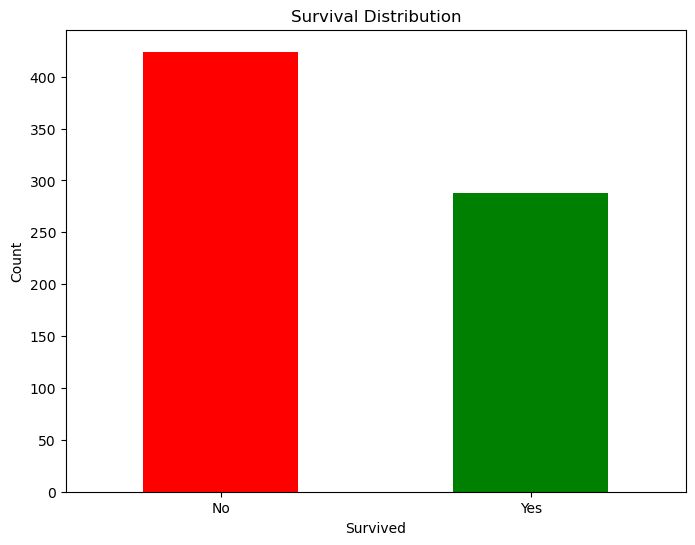

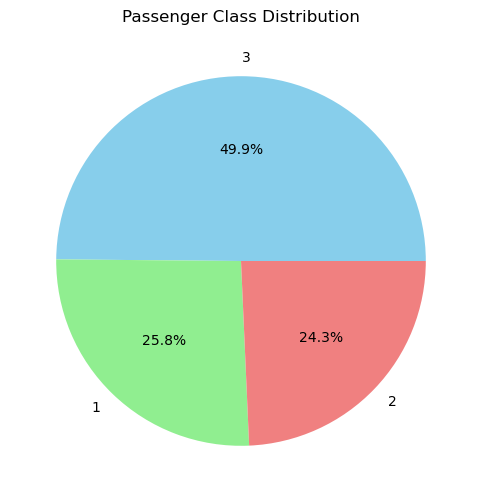

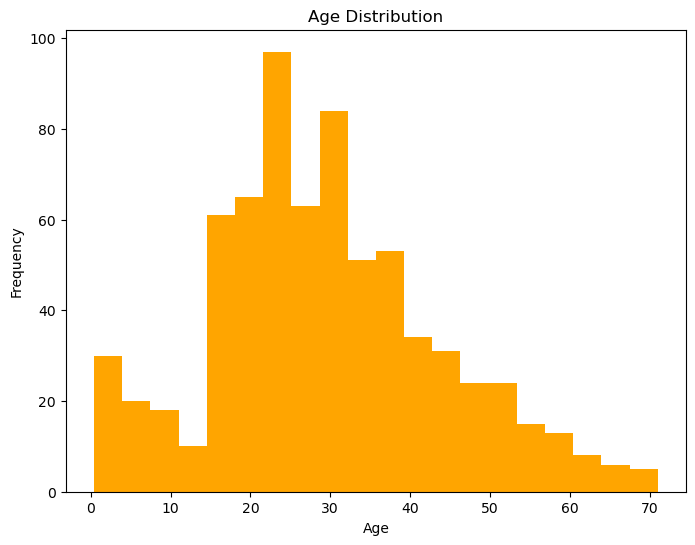

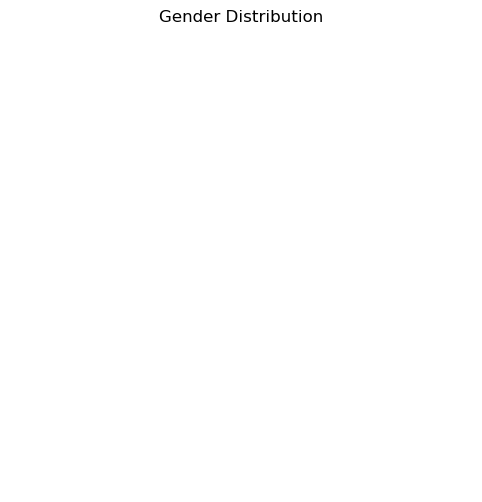

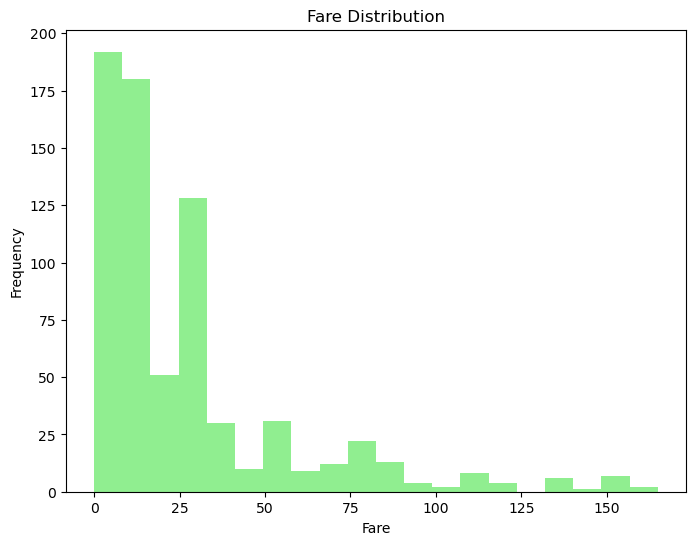

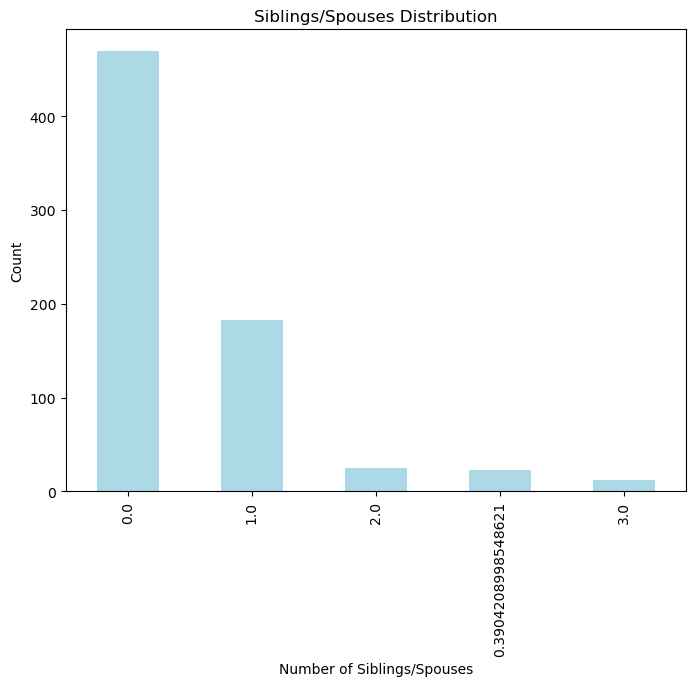

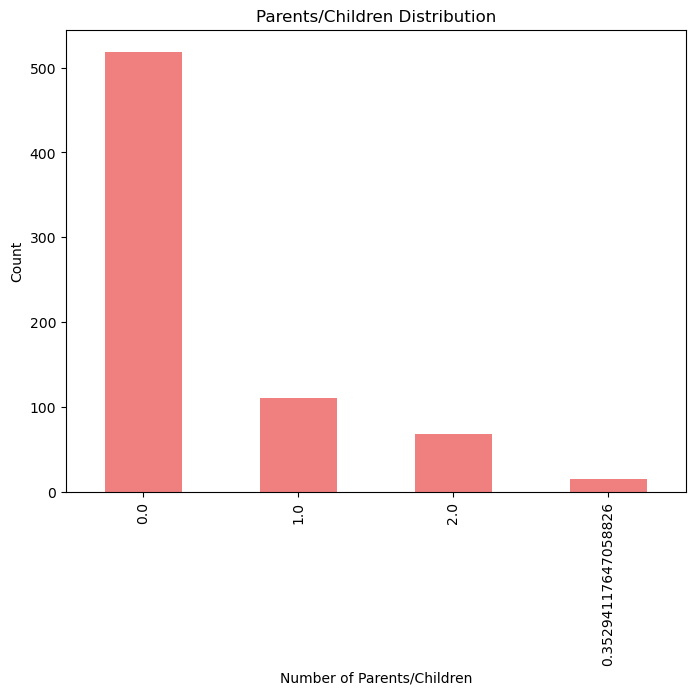

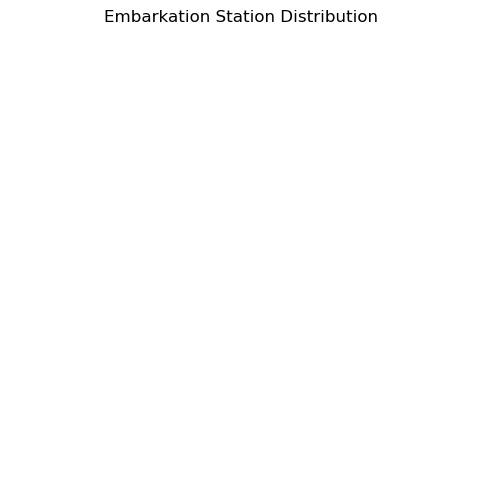

In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import numpy as np

class TrainCrashAnalysis:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = self.load_data()
    
    def load_data(self):
        data = pd.read_csv(self.file_path)
        return data

    def clean_data(self):
        self.data.dropna(inplace=True)
        self.records_count = len(self.data)
        print(f"Data cleaning complete. Number of records after cleaning: {self.records_count}")
        
    def station_with_most_passengers(self):
        station_counts = self.data['station'].value_counts()
        most_passengers_station = station_counts.idxmax()
        print(f"The station from which the train picked the most passengers is: {most_passengers_station}")

    def explore_data(self):
        print("Displaying head of the data:")
        print(self.data.head())
        print("\nDisplaying data info:")
        print(self.data.info())
        print("\nDisplaying data description:")
        print(self.data.describe())
        print("\nDisplaying number of unique values for each column:")
        print(self.data.nunique())
    
    def detect_and_treat_outliers(self):
        """Detect and treat outliers using Z-score method."""
        numerical_cols = self.data.select_dtypes(include=np.number).columns
        z_scores = np.abs((self.data[numerical_cols] - self.data[numerical_cols].mean()) / self.data[numerical_cols].std())
        threshold = 3
        self.data[z_scores > threshold] = np.nan
        self.data = self.data.apply(pd.to_numeric, errors='coerce')
        self.data.fillna(self.data.mean(), inplace=True)
    
        print("Outliers treated.")

        
    

    def partition_data(self):
        if 'sex' not in self.data.columns:
            raise KeyError("Column 'sex' does not exist in the DataFrame.")

        X = self.data.drop(['survived', 'station'], axis=1)
        y = self.data['survived']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

        print("Data partitioning complete.")
        return X_train, X_test, y_train, y_test
    
    def preprocess_data(self, X_train, X_test):

        X_concatenated = pd.concat([X_train, X_test], axis=0)

        categorical_columns = X_concatenated.select_dtypes(include=['object']).columns

        for col in categorical_columns:
            X_concatenated[col] = X_concatenated[col].fillna('unknown')

        encoder = OneHotEncoder(drop='first', sparse_output=False)
        X_encoded = encoder.fit_transform(X_concatenated)

        X_train_encoded = X_encoded[:len(X_train)]
        X_test_encoded = X_encoded[len(X_train):]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_encoded)
        X_test_scaled = scaler.transform(X_test_encoded)

        return X_train_scaled, X_test_scaled
    
    def find_best_k(self, X_train, y_train):
        """Find the best value of k using grid search."""
  
        param_grid = {'n_neighbors': range(1, 21)}  # Trying k values from 1 to 20

        knn = KNeighborsClassifier()

        grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

        grid_search.fit(X_train, y_train)

        best_k = grid_search.best_params_['n_neighbors']

        print(f"The best value of k is: {best_k}")

        return best_k

    def build_best_knn_model(self, X_train, X_test, y_train, y_test):
      
        best_k = self.find_best_k(X_train, y_train)


        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train, y_train)

  
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)

 
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        print(f"KNN Train Accuracy (k={best_k}): {train_accuracy:.2f}")
        print(f"KNN Test Accuracy (k={best_k}): {test_accuracy:.2f}")

        return train_accuracy, test_accuracy
    def find_best_logistic_regression_model(self, X_train, y_train):
       
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],  
            'penalty': ['l1', 'l2'] 
        }

      
        logistic_regression = LogisticRegression(solver='liblinear')

      
        grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_

        print("Best Parameters for Logistic Regression:", best_params)

      
        best_logistic_regression = LogisticRegression(**best_params, solver='liblinear')

        return best_logistic_regression

    def evaluate_model(self, model, X_train, X_test, y_train, y_test):
        """Evaluate the model's accuracy on training and testing data."""
       
        model.fit(X_train, y_train)

     
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

   
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        print(f"Logistic Regression Train Accuracy: {train_accuracy:.2f}")
        print(f"Logistic Regression Test Accuracy: {test_accuracy:.2f}")

        return train_accuracy, test_accuracy
    
    def build_decision_tree_model(self, X_train, X_test, y_train, y_test, max_depth=None):
        """Build a Decision Tree model and return the accuracy."""
        dt_classifier = DecisionTreeClassifier(max_depth=max_depth)
        dt_classifier.fit(X_train, y_train)
        y_train_pred = dt_classifier.predict(X_train)
        y_test_pred = dt_classifier.predict(X_test)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Decision Tree Train Accuracy (max_depth={max_depth}): {train_accuracy:.2f}")
        print(f"Decision Tree Test Accuracy (max_depth={max_depth}): {test_accuracy:.2f}")
        return train_accuracy, test_accuracy
    
    def plot_data(self):
        plt.figure(figsize=(8, 6))
        self.data['survived'].value_counts().plot(kind='bar', color=['red', 'green'])
        plt.title('Survival Distribution')
        plt.xlabel('Survived')
        plt.ylabel('Count')
        plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
        plt.show()

        
        plt.figure(figsize=(8, 6))
        self.data['pclass'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
        plt.title('Passenger Class Distribution')
        plt.ylabel('')
        plt.show()

        plt.figure(figsize=(8, 6))
        self.data['age'].plot(kind='hist', bins=20, color='orange')
        plt.title('Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Frequency')
        plt.show()

      
        plt.figure(figsize=(8, 6))
        self.data['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightpink'])
        plt.title('Gender Distribution')
        plt.ylabel('')
        plt.show()

    
        plt.figure(figsize=(8, 6))
        self.data['fare'].plot(kind='hist', bins=20, color='lightgreen')
        plt.title('Fare Distribution')
        plt.xlabel('Fare')
        plt.ylabel('Frequency')
        plt.show()

       
        plt.figure(figsize=(8, 6))
        self.data['sibsp'].value_counts().plot(kind='bar', color='lightblue')
        plt.title('Siblings/Spouses Distribution')
        plt.xlabel('Number of Siblings/Spouses')
        plt.ylabel('Count')
        plt.show()

        plt.figure(figsize=(8, 6))
        self.data['parch'].value_counts().plot(kind='bar', color='lightcoral')
        plt.title('Parents/Children Distribution')
        plt.xlabel('Number of Parents/Children')
        plt.ylabel('Count')
        plt.show()

        
        plt.figure(figsize=(8, 6))
        self.data['station'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'])
        plt.title('Embarkation Station Distribution')
        plt.ylabel('')
        plt.show()

    
analysis = TrainCrashAnalysis("/Users/kudaravalliamuktha/Desktop/Python project files and prog/TrainData.csv")

analysis.clean_data()
analysis.station_with_most_passengers()
analysis.explore_data()
analysis.detect_and_treat_outliers()

X_train, X_test, y_train, y_test = analysis.partition_data()

X_train_processed, X_test_processed = analysis.preprocess_data(X_train, X_test)


train_accuracy, test_accuracy = analysis.build_best_knn_model(X_train_processed, X_test_processed, y_train, y_test)

print("KNN Model Accuracy:")
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

best_logistic_regression_model = analysis.find_best_logistic_regression_model(X_train_processed, y_train)

train_accuracy, test_accuracy = analysis.evaluate_model(best_logistic_regression_model, X_train_processed, X_test_processed, y_train, y_test)


print("Logistic Regression Model Accuracy:")
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


tree_depths = [None, 3, 5, 10, 15]

accuracy_results = []


for depth in tree_depths:
    train_accuracy, test_accuracy = analysis.build_decision_tree_model(X_train_processed, X_test_processed, y_train, y_test, max_depth=depth)
    accuracy_results.append((depth, train_accuracy, test_accuracy))


best_depth = max(accuracy_results, key=lambda x: x[2])[0]

print(f"The ideal tree depth is: {best_depth}")

analysis.plot_data()